<a href="https://colab.research.google.com/github/chuy-zip/PROYECTO2_DS/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chuy-zip/PROYECTO2_DS.git

Cloning into 'PROYECTO2_DS'...
remote: Enumerating objects: 4239, done.
remote: Counting objects: 100% (4239/4239), done.
remote: Compressing objects: 100% (4227/4227), done.
remote: Total 4239 (delta 18), reused 4219 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (4239/4239), 10.65 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (4200/4200), done.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords as nltk_stop
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import requests

In [3]:
df = pd.read_csv("PROYECTO2_DS/data/train_clean.csv")

In [4]:
df.head()

,Unnamed: 0,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
0,0,0013cc385424,007ACE74B050,Lead,Adequate,hi isaac going writing face mar natural landfo...
1,1,9704a709b505,007ACE74B050,Position,Adequate,perspective think face natural landform dont t...
2,2,c22adee811b6,007ACE74B050,Claim,Adequate,think face natural landform no life mar descov...
3,3,a10d361e54e4,007ACE74B050,Evidence,Adequate,life mar would know reason think natural landf...
4,4,db3e453ec4e2,007ACE74B050,Counterclaim,Adequate,people thought face formed alieans thought lif...


## Análisis exploratorio

El set de datos con el que estaremos trabajando será principalmente partes de ensayos de estudiantes, con el fin de encontrar que elementos conforman un mejor argumento, tomando en cuenta cosas como el tipo de discurso, effectividad y el texto procesado. Lo primero es remover la columna sin nombre. Esta no será de utilidad ya que es únicamente un índice.

In [5]:
df = df.drop('Unnamed: 0', axis=1)
df.columns

Index(['discourse_id', 'essay_id', 'discourse_type', 'discourse_effectiveness',
       'text_clean'],
      dtype='object')

In [6]:
df.shape

(36765, 5)

Contamos entonces con un total de 5 columnas distintas

In [7]:
df.describe()

,discourse_id,essay_id,discourse_type,discourse_effectiveness,text_clean
count,36765,36765,36765,36765,36752
unique,36765,4191,7,3,36316
top,c8a973681feb,91B1F82B2CF1,Evidence,Adequate,summer project
freq,1,23,12105,20977,33


Podemos ver que principalmente hay variacionees en el tipo de discurso, con 7 tipos distintos y también 3 tipos de efectividad distinta. En este punto no es necesario revisar por valores vacíos, ya que estos ya fueron manejados en la limpieza del data set. Por lo que ahora es mejor analizar la distribución de frecuencia de los tipos de discursos y la efectividad.

### Frecuencia de los distintos tipos de discurso

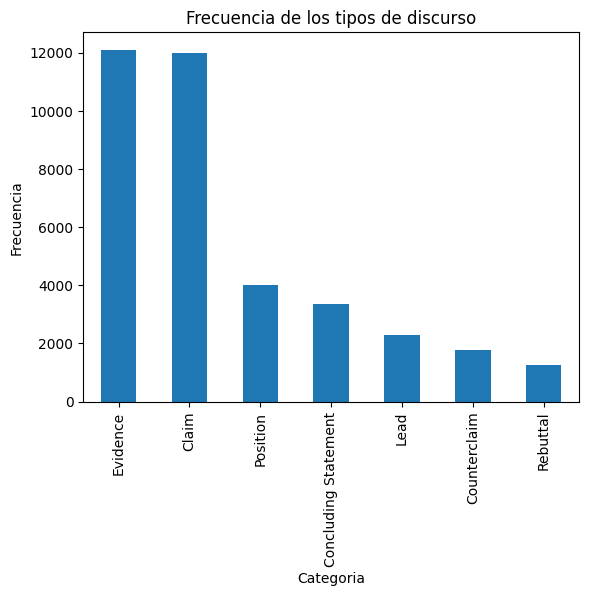

In [8]:
df["discourse_type"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de discurso")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

Podemos ver que el tipo de discurso más común es el de evidence seguido por claim. Ambos tienen un distribución muy parecida, mientras que los demas tipos son significativamente más pequeños.

### Frecuencia de los distintos tipos de efectividad en discursos

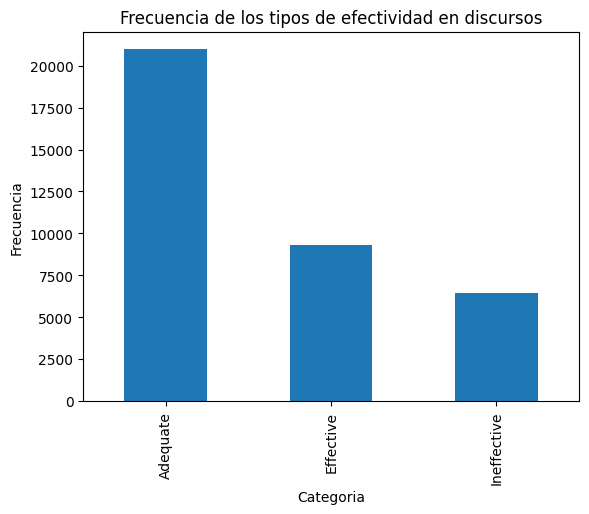

In [9]:
df["discourse_effectiveness"].value_counts().plot(kind='bar')
plt.title("Frecuencia de los tipos de efectividad en discursos")
plt.xlabel("Categoria")
plt.ylabel("Frecuencia")
plt.show()

En este caso es interesante ver que realmente los datos no están balanceados en lo que respecta a las clases que son el objetivo. Hay bastante más columnas relacionadas a la efectividad "Adequate", por loque tal vez valdría la pena hacer downsampling al momento de tener que entrenar un modelo.

### Caracteristicas de columna de texto

Ahora viendo los resultados de frecuencia es necesario analizar la última columna y seguramente la más importante, text_clean.

In [10]:
#funciones para poder calcular características del texto

# Densidad léxica osea la cantidad de palabras únicas / total palabras
def lexical_density(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

# longitud promedio de las palabras
def avg_word_length(text):
    words = str(text).split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

In [11]:
# obtener estadisticas simples del texto

df['text_char_count'] = df['text_clean'].str.len()

df['text_word_count'] = df['text_clean'].str.split().str.len()

df['avg_word_length'] = df['text_clean'].apply(avg_word_length)

df['lexical_density'] = df['text_clean'].apply(lexical_density)

In [12]:
# Estadísticas por discourse_type
print("\n--- DENSIDAD DE TEXTO POR EFFECTIVIDAD ---")
lexical_density_stats = df.groupby('discourse_effectiveness').agg({
    'lexical_density': 'mean'
}).round(2)
print(lexical_density_stats)


print("\n--- TAMAÑO PROMEDIO DE LAS PALABRAS POR EFFECTIVIDAD ---")
avg_word_length_stats = df.groupby('discourse_effectiveness').agg({
    'avg_word_length': 'mean'
}).round(2)
print(avg_word_length_stats)


# la diferencia es que este es la estadistica para la cantidad de las palabras en los textos
print("\n--- ESTADISTICAS DE CANTIDAD DE PALABRAS POR EFFECTIVIDAD ---")
text_word_count_stats = df.groupby('discourse_effectiveness').agg({
    'text_word_count': ['mean', 'std', 'count'],
}).round(2)
print(text_word_count_stats)

# y este es del largo del texto en baes a caracteres
print("\n--- ESTADISTICAS DE LARGO DEL TEXTO POR EFFECTIVIDAD ---")
text_char_count_stats = df.groupby('discourse_effectiveness').agg({
    'text_char_count': ['mean', 'std', 'count'],
}).round(2)
print(text_char_count_stats)





--- DENSIDAD DE TEXTO POR EFFECTIVIDAD ---
                         lexical_density
discourse_effectiveness                 
Adequate                            0.92
Effective                           0.87
Ineffective                         0.89

--- TAMAÑO PROMEDIO DE LAS PALABRAS POR EFFECTIVIDAD ---
                         avg_word_length
discourse_effectiveness                 
Adequate                            5.78
Effective                           6.11
Ineffective                         5.66

--- ESTADISTICAS DE CANTIDAD DE PALABRAS POR EFFECTIVIDAD ---
                        text_word_count              
                                   mean    std  count
discourse_effectiveness                              
Adequate                          17.13  15.43  20967
Effective                         31.75  28.91   9326
Ineffective                       23.77  29.71   6459

--- ESTADISTICAS DE LARGO DEL TEXTO POR EFFECTIVIDAD ---
                        text_char_count    

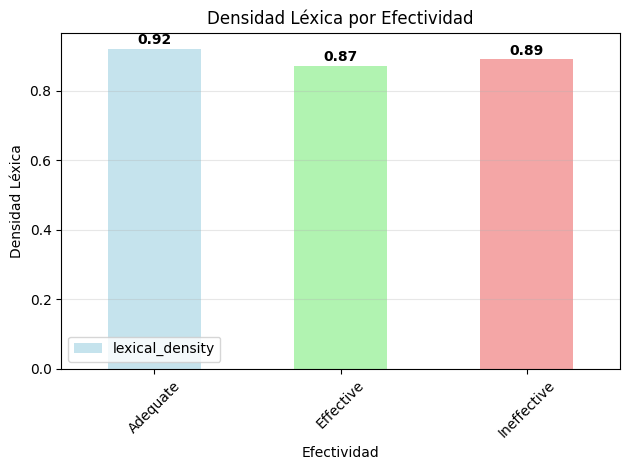

In [13]:
lexical_density_stats.plot(kind='bar', y='lexical_density',
                          color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
plt.title("Densidad Léxica por Efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Densidad Léxica")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(lexical_density_stats['lexical_density']):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Es interesante observar que realmente la densidad léxica promedio no varía mucho entre los distintos discursos y que la que tiene menor densidad, son las que estan marcados como Effective.

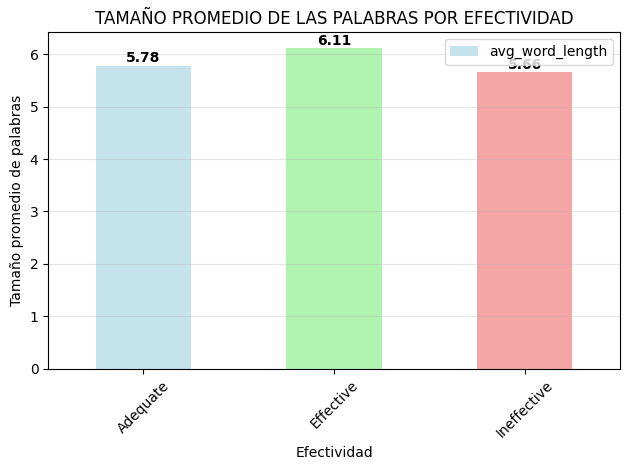

In [14]:
avg_word_length_stats.plot(kind='bar', y='avg_word_length',
                          color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
plt.title("TAMAÑO PROMEDIO DE LAS PALABRAS POR EFECTIVIDAD")
plt.xlabel("Efectividad")
plt.ylabel("Tamaño promedio de palabras")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(avg_word_length_stats['avg_word_length']):
    plt.text(i, v + 0.005, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Pero al ver la efectividad en comparación con el largo de las palabras, podemos ver que los argumentos usan palabras un poco más largas en promedio en comparación a las otras 2 clases.

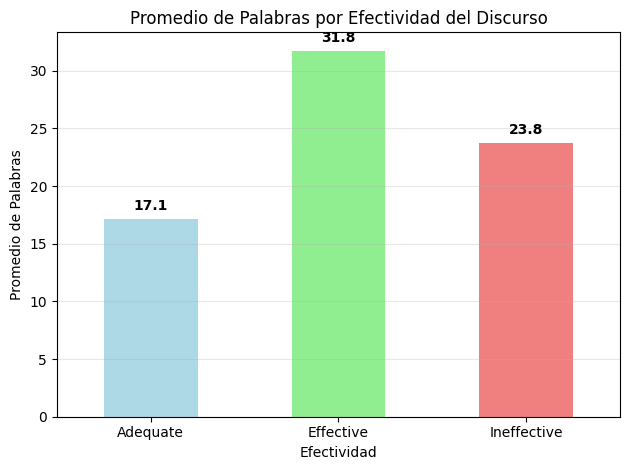

In [15]:
# Gráfico de promedio de palabras por efectividad
text_word_count_stats['text_word_count']['mean'].plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title("Promedio de Palabras por Efectividad del Discurso")
plt.xlabel("Efectividad")
plt.ylabel("Promedio de Palabras")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Añadir los valores en las barras
for i, v in enumerate(text_word_count_stats['text_word_count']['mean']):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

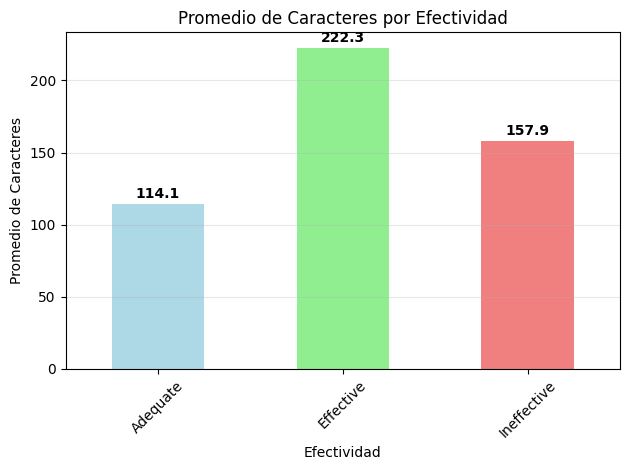

In [16]:
text_char_count_stats['text_char_count']['mean'].plot(kind='bar', y='mean', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title("Promedio de Caracteres por Efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Promedio de Caracteres")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, v in enumerate(text_char_count_stats['text_char_count']['mean']):
    plt.text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Con estos últimos 2 gráficos podemos ver que si parece haber una relación entre el largo de los enunciados y la efectividad. Estas 2 gráficas son muy similares puesto que un texto con varias palabras también será más largo. Por lo que la columna de promedio de caracteres puede ser redundante en el futuro. Pero si se ve una diferencia significativa entre las clases al tener en mente el largo del argumento.

In [17]:
df.columns

Index(['discourse_id', 'essay_id', 'discourse_type', 'discourse_effectiveness',
       'text_clean', 'text_char_count', 'text_word_count', 'avg_word_length',
       'lexical_density'],
      dtype='object')

### Análisis de la longitud de los textos por efectividad del discurso

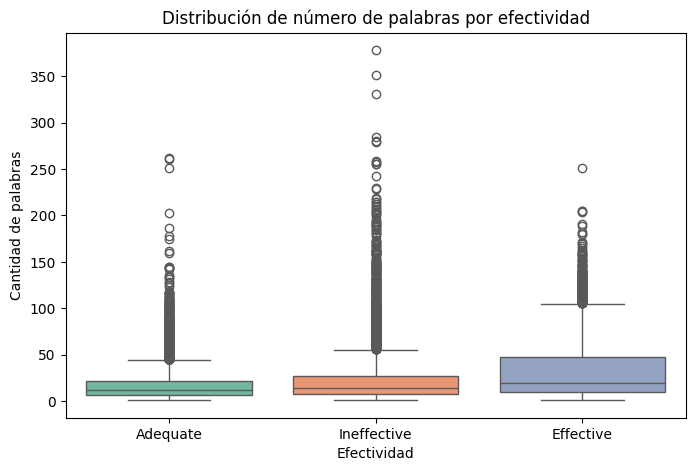

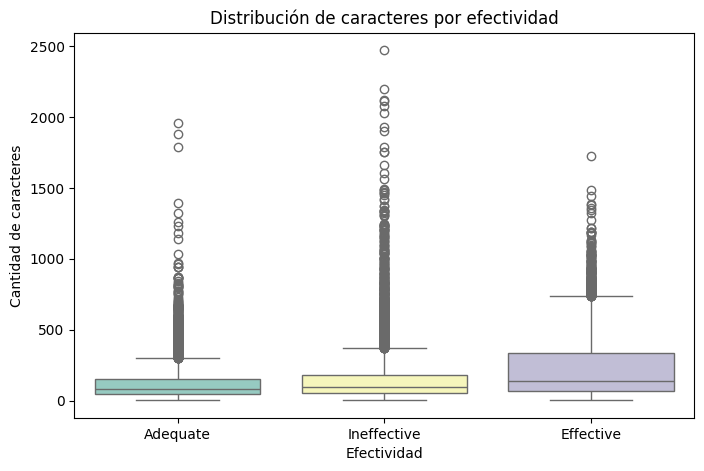

In [18]:
import seaborn as sns

# Boxplot de cantidad de palabras por efectividad
plt.figure(figsize=(8,5))
sns.boxplot(x="discourse_effectiveness", y="text_word_count", data=df, palette="Set2")
plt.title("Distribución de número de palabras por efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Cantidad de palabras")
plt.show()

# Boxplot de longitud de caracteres por efectividad
plt.figure(figsize=(8,5))
sns.boxplot(x="discourse_effectiveness", y="text_char_count", data=df, palette="Set3")
plt.title("Distribución de caracteres por efectividad")
plt.xlabel("Efectividad")
plt.ylabel("Cantidad de caracteres")
plt.show()


De estas graficas se pueden sacar varios puntos fuertes.

El pimero es que se puede observar como los textos catalogados como Effective tienden a ser más extensos, con una mediana mayor que las demas cajas. En Adequate e Ineffective los textos suelen ser más cortos, pero hay una alta existencia de casos atipicos, lo que indica que hay discursos que se extienden mucho más de lo esperado. Por lo tanto, los textos más largos tienden a ser percibidos como más efectivos, aunque no siempre es el caso.

En cuanto a los caracteres se puede observar que los discursos Effective muestran longitudes más grandes en caracteres. anto Adequate como Ineffective presentan distribuciones similares en la parte central, pero con gran cantidad de outliers. Esos valores extremos son relevantes porque indican que existen casos atípicos de discursos muy largos que no necesariamente son efectivos, lo que podría ser ruido o incluso señales de redacción poco clara.

En el caso de los datos atipicos, En ambas gráficas se observan muchos puntos fuera de los bigotes. Estos representan discursos con extensiones muy superiores al rango esperado. La abundancia de estos puntos sugiere que la longitud del texto no es un predictor suficiente de la efectividad, aunque la tendencia general apunta a que los textos efectivos son más largos, también existen textos muy extensos que terminan siendo clasificados como ineficaces.

### Analisis de los bigramas y trigramas de cada categoría.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=10):
    # Convertir NaN a string vacío y asegurar que todo sea str
    corpus = corpus.dropna().astype(str)

    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

for eff in df['discourse_effectiveness'].unique():
    subset = df[df['discourse_effectiveness'] == eff]

    # BIGRAMAS
    print("#---BIGRAMAS---#")
    print(f"\nBigramas más comunes en {eff}:")
    print(get_top_ngrams(subset['text_clean'], ngram_range=(2,2)))

    # TRIGRAMAS
    print("#---TRIGRAMAS---#")
    print(f"\nTrigramas más comunes en {eff}:")
    print(get_top_ngrams(subset['text_clean'], ngram_range=(3,3)))


#---BIGRAMAS---#

Bigramas más comunes en Adequate:
[('electoral college', np.int64(2898)), ('popular vote', np.int64(973)), ('community service', np.int64(765)), ('cell phone', np.int64(611)), ('driverless car', np.int64(608)), ('electoral vote', np.int64(507)), ('vote president', np.int64(467)), ('united state', np.int64(414)), ('face mar', np.int64(402)), ('summer project', np.int64(350))]
#---TRIGRAMAS---#

Trigramas más comunes en Adequate:
[('electoral college unfair', np.int64(204)), ('election popular vote', np.int64(203)), ('facial action coding', np.int64(202)), ('attend class home', np.int64(174)), ('president united state', np.int64(161)), ('popular vote president', np.int64(122)), ('think electoral college', np.int64(121)), ('venus worthy pursuit', np.int64(113)), ('cell phone school', np.int64(107)), ('electoral college vote', np.int64(104))]
#---BIGRAMAS---#

Bigramas más comunes en Ineffective:
[('electoral college', np.int64(1143)), ('popular vote', np.int64(362)), ('e

En cuanto a los temas podemos observar como “electoral college”, “popular vote”, “vote president” y “united state” aparecen con alta frecuencia tanto en discursos Adequate, Ineffective como Effective. Se podria afirmar que se suelen abordar los mismos temas.

En los discursos adequate se presentan n-gramas más neutrales o desbalanceados como “electoral college unfair”, “election popular vote”, “cell phone school". Indican que los textos tienden a mencionar los temas esperados, pero sin una profundidad argumentativa clara.

En los discursos Ineffective se pueden observar temas como “electoral college process”, “required elect president”, “vote required elect”. Esto sugiere que los textos ineficaces tienden a repetir frases estructurales sin un buena analisis.

En lso discursos Effective, aparte de los temas ya mencionados, se observan temas más complejos como “community service”, “driverless car”, “distance learning”, “extracurricular activity”. Los trigramas como “make better choice”, “participate extracurricular activity”, “student design project” denotan argumentos prácticos.

### Nube de palabras por tipo de efectividad


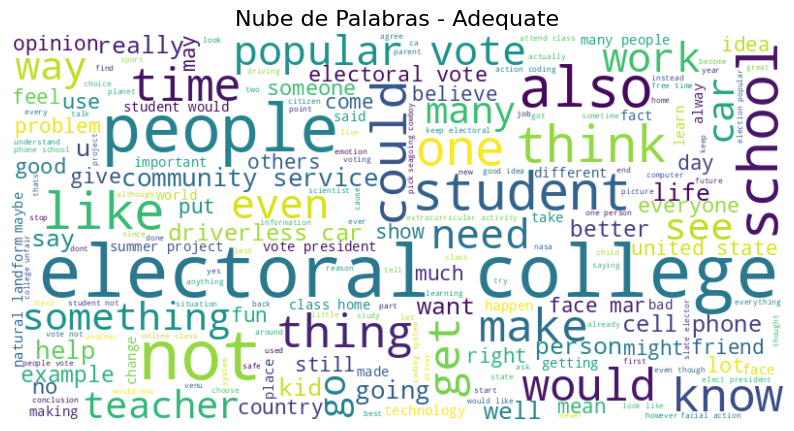

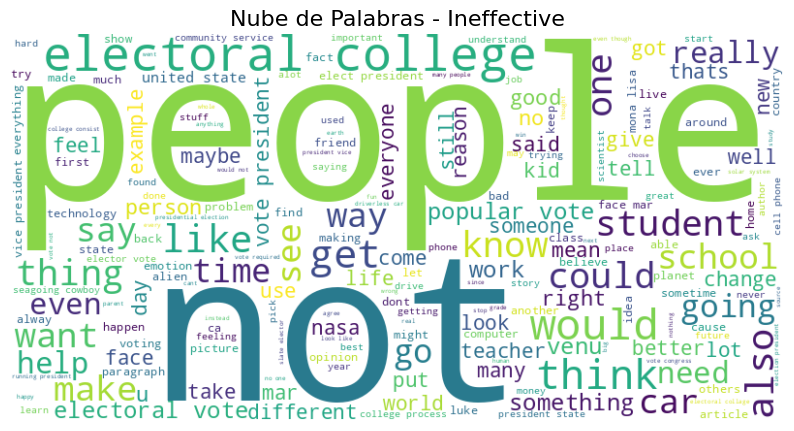

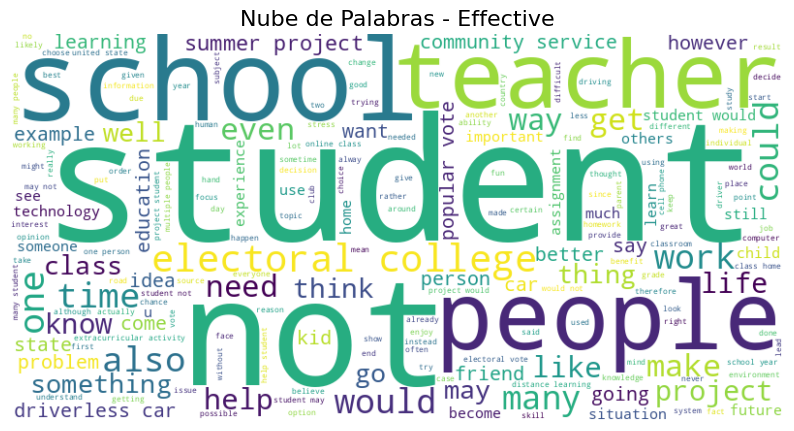

In [21]:
from wordcloud import WordCloud

for eff in df['discourse_effectiveness'].unique():
    subset = df[df['discourse_effectiveness'] == eff]
    text = " ".join(subset['text_clean'].astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color="white",
                          colormap="viridis", stopwords="english").generate(text)

    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nube de Palabras - {eff}", fontsize=16)
    plt.show()


En adequate se repiten mas las palabras: “electoral college”, “people”, “student”, “school”.

En ineffective se repiten mas las palabras: “people”, “not”, “electoral college”, “student”. De aqui se puede notar como hay un uso excesivo de las negaciones

En effective se piten mas las palabras: “student”, “school”, “teacher”, “people”, “project”, “work”. Se puede observar como aca aparecen palabras mas centradas en educacion, aprendizaje y actividades.

### Visualización de la agrupación de textos según efectividad

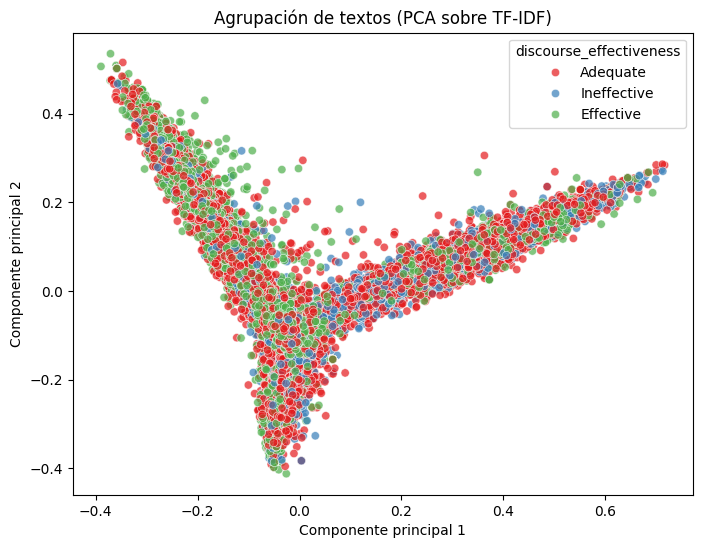

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X = vectorizer.fit_transform(df['text_clean'].astype(str))

# PCA a 2D
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(X.toarray())

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=df['discourse_effectiveness'], palette="Set1", alpha=0.7)
plt.title("Agrupación de textos (PCA sobre TF-IDF)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()


Se observa que las tres categorías aparecen muy mezcladas en el espacio reducido. No hay fronteras claras entre los grupos, lo cual indica que los textos comparten mucho vocabulario común y que la clasificación no es trivial solo a partir de la frecuencia de palabras.

El resultado confirma que la clasificación entre discursos efectivos e ineficaces no se explica fácilmente por diferencias léxicas superficiales. Esto implica que será necesario considerar otras características adicionales como sintaxis, complejidad semántica. Para mejorar la separación entre clases.

### Distribución porcentual de la efectividad según el tipo de discursos

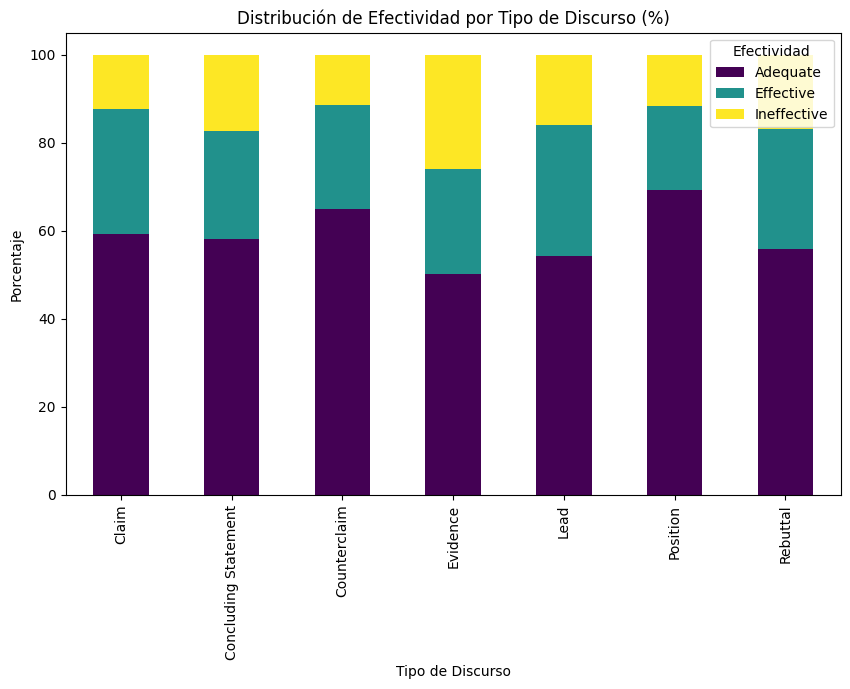

In [23]:
cross_tab = pd.crosstab(df['discourse_type'], df['discourse_effectiveness'], normalize='index') * 100
cross_tab.plot(kind='bar', stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribución de Efectividad por Tipo de Discurso (%)")
plt.ylabel("Porcentaje")
plt.xlabel("Tipo de Discurso")
plt.legend(title="Efectividad")
plt.show()


En la distribucion se puede observar como en todos los tipos de discurso, la mayor proporción se concentra en la categoría Adequate. Esto indica que la mayor parte de los discursos cumplen mínimamente con el estándar. Effective es la minoria en todos los casos.

### Longitud de los textos según tipo de discurso

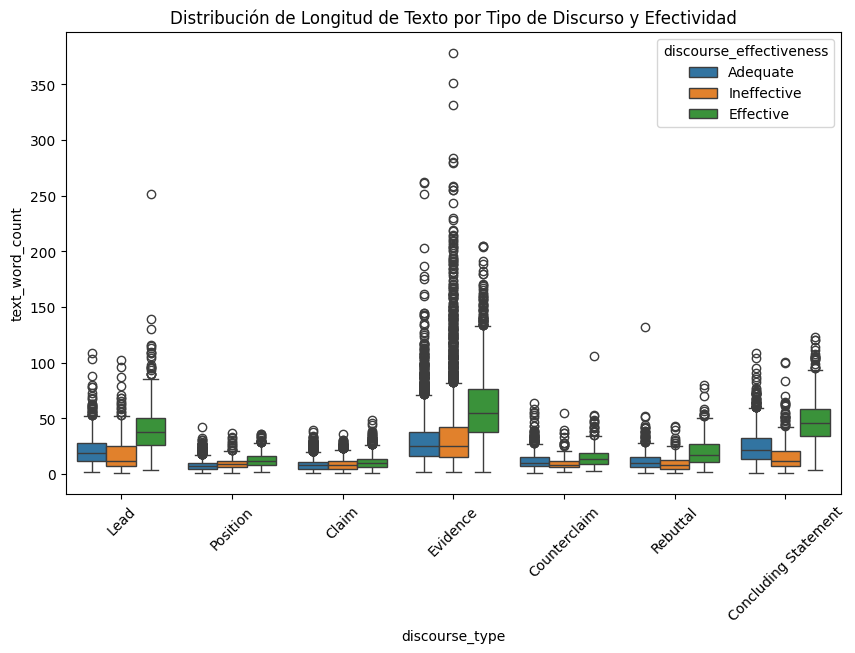

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x="discourse_type", y="text_word_count", hue="discourse_effectiveness", data=df)
plt.title("Distribución de Longitud de Texto por Tipo de Discurso y Efectividad")
plt.xticks(rotation=45)
plt.show()


os textos clasificados como Evidence son los más largos en cantidad de palabras. Se observa también la mayor cantidad de los casos atipicos, lo que refleja que algunos discursos intentan justificar en excesos.

Lead, evidence y Concluding Statement son las categorias que tienden a tener textos mas largos que otros tipos de discurso. Tambien, se puede observar como estas mismas cateforias tienen un alto rango superior la efectividad.

### Medidas de complejidad léxica por categoría

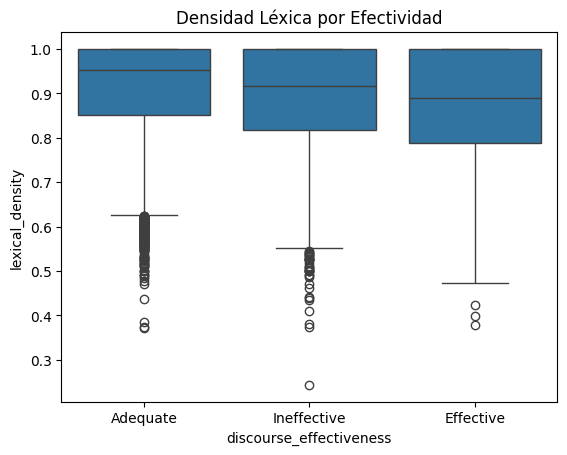

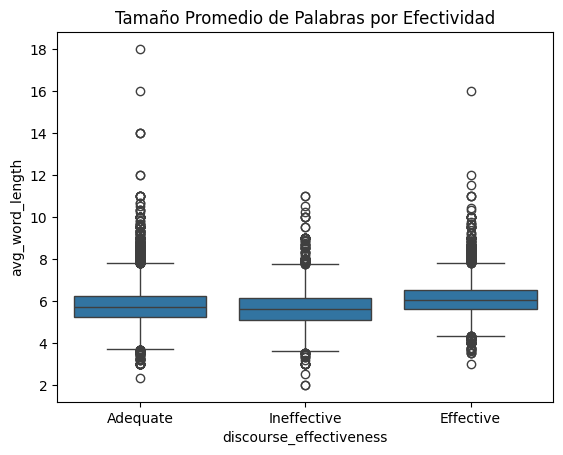

In [30]:
sns.boxplot(x="discourse_effectiveness", y="lexical_density", data=df)
plt.title("Densidad Léxica por Efectividad")
plt.show()

sns.boxplot(x="discourse_effectiveness", y="avg_word_length", data=df)
plt.title("Tamaño Promedio de Palabras por Efectividad")
plt.show()

La densidad léxica es alta en los tres grupo. Esto indica que los discursos utilizan en gran medida palabras con contenido semántico, es decir, sustantivos, adjetivos, verbos y adverbios, en lugar de palabras funcionales. Tambien, se puede observar como hay casos atipicos bajo lo que indica que en los discursos tiene que existir cierta redundancia o un lenguaje poco variado.

Del tamaño de las palabras se puede obsrevar como se mantiene un promedio de 5 a 6 caracteres. Auque los discursoso effective tienden a tenre una media mas alta,

### Top palabras diferenciadoras (TF-IDF por clase)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=20)
for eff in df['discourse_effectiveness'].unique():
    subset = df[df['discourse_effectiveness'] == eff]['text_clean'].dropna().astype(str)
    tfidf_matrix = tfidf.fit_transform(subset)
    scores = zip(tfidf.get_feature_names_out(), tfidf.idf_)
    print(f"\nPalabras más relevantes (TF-IDF alto) en {eff}:")
    print(sorted(scores, key=lambda x: x[1], reverse=True)[:10])



Palabras más relevantes (TF-IDF alto) en Adequate:
[('venus', np.float64(3.8303083726107543)), ('class', np.float64(3.786032366231385)), ('car', np.float64(3.6502799307354437)), ('president', np.float64(3.617729730616761)), ('know', np.float64(3.6034530442600783)), ('state', np.float64(3.5470824549908686)), ('want', np.float64(3.5295752164078484)), ('way', np.float64(3.528976951358595)), ('thing', np.float64(3.470324438929034)), ('make', np.float64(3.378249759982858))]

Palabras más relevantes (TF-IDF alto) en Ineffective:
[('car', np.float64(3.8817403849508767)), ('planet', np.float64(3.72365114154469)), ('school', np.float64(3.6037738642851918)), ('elector', np.float64(3.570849079588725)), ('face', np.float64(3.4172769360807562)), ('student', np.float64(3.3747896622414397)), ('want', np.float64(3.3731271514678265)), ('venus', np.float64(3.3229141746324715)), ('know', np.float64(3.2948749545680784)), ('time', np.float64(3.2395957588433038))]

Palabras más relevantes (TF-IDF alto) en 

En los discursos clasificados como adecuados, aparecen términos como “venus”, “class”, “president” y “state”, otras palabras como “know”, “want” y “thing”.

Los discursos inefectivos están marcados por términos como “car”, “planet”, “face”, y “student”, junto a expresiones vagas como “want”, “know” y “time”.

En los discursos efectivos, destacan términos como “online”, “summer”, “learning”, “vote”, “electoral” y “college”.

### Balance de clases

In [27]:
df['discourse_effectiveness'].value_counts(normalize=True) * 100


,proportion
discourse_effectiveness,
Adequate,57.056984
Effective,25.366517
Ineffective,17.576499


Se puede observar como el dataser esta desbalanceado en clases.

# Hallazgos y conclusiones
* La categoría Adequate representa más del 57% de los datos, mientras que Effective al rededor de 25% e Ineffective 18% tienen menos representación. Por lo tanto existe un desbalance de clases.
* Los discursos Effective tienden a ser más largos (en cantidad de palabras y caracteres) en comparación con los Adequate e Ineffective.
* En general, los tres grupos (Adequate, Ineffective, Effective) presentan densidades léxicas altas, pero los Effective muestran mayor consistencia en valores elevados.

---
* Los discursos inefectivos repiten más palabras generales (menos específicos), lo que muestra menor profundidad en el argumento.
* La longitud por sí sola no determina la efectividad aunque los Effective suelen ser más extensos, hay Adequate largos y Effective cortos. La clave está en el uso variado y estructurado del lenguaje.